In [72]:
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import seaborn as sns

In [73]:
US_POPN = 328_200_000

In [80]:
timeseries_tests = pd.DataFrame(requests.get("https://covidtracking.com/api/states/daily").json())
timeseries_tests['stateName'] = timeseries_tests.state
timeseries_tests.dateChecked = timeseries_tests.dateChecked.str.replace("T24", "T00")
timeseries_tests['dateColumn'] = pd.to_datetime(timeseries_tests.dateChecked)
timeseries_tests = timeseries_tests.sort_values('dateColumn')
timeseries_tests['pct_us_popn'] = 100*timeseries_tests.positive / US_POPN

In [81]:
votes = pd.read_csv(
    "./data-resources/StateAbbreviations.csv", index_col="Postalcode"
).join(
    pd.read_csv("./data-resources/state-electoral-2016.csv", index_col="State"), on="State"
)

In [82]:
timeseries_tests["state_popn"] = timeseries_tests.state.map(lambda s: votes.loc[s].Pop)
timeseries_tests["test_pos_state_popn"] = 100*timeseries_tests.positive / timeseries_tests.state_popn
timeseries_tests["death_pct_state_popn"] = 100*timeseries_tests.death / timeseries_tests.state_popn

In [83]:
timeseries_tests = timeseries_tests[
    (~pd.isna(timeseries_tests.positive)) &
    (~pd.isna(timeseries_tests.dateColumn)) 
]

In [84]:
pos_tests_pct = timeseries_tests.fillna(0).groupby("stateName").test_pos_state_popn.max().sort_values()

## top 10 most cases by popn:

Text(0.5, 1.0, 'Positive tests as a Percentage of Population')

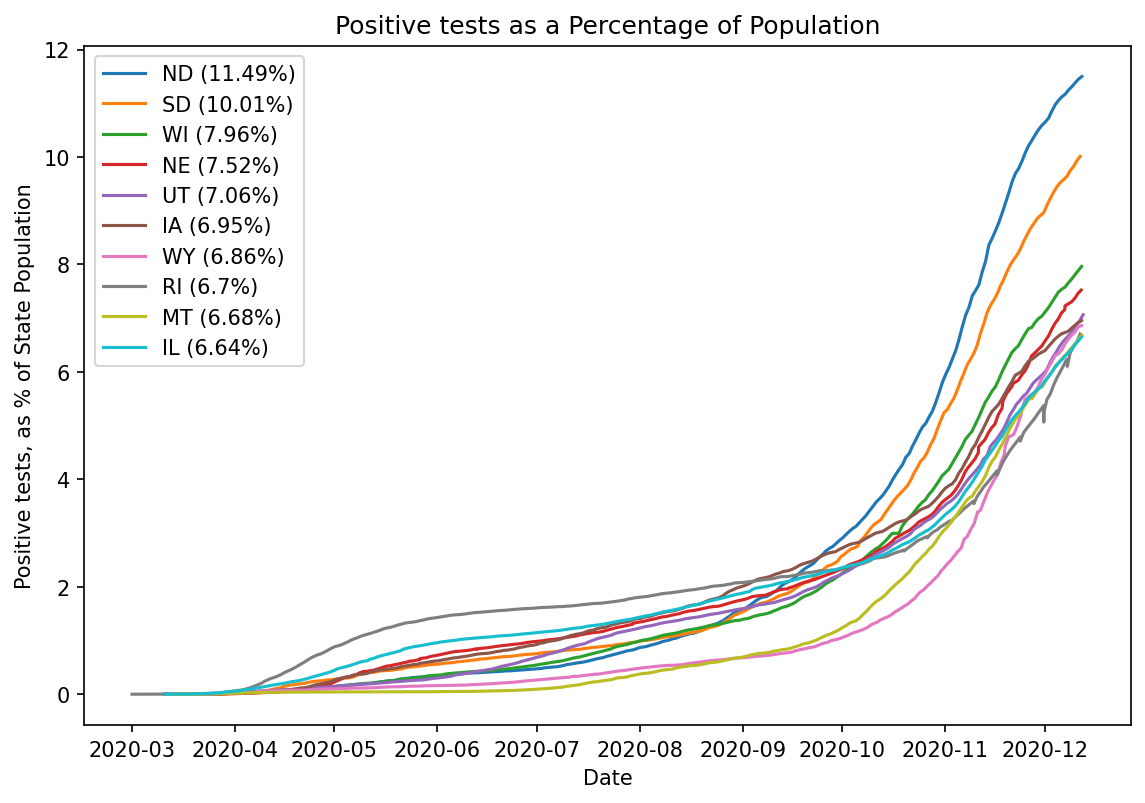

In [85]:
to_render = timeseries_tests[
    timeseries_tests.state.isin(pos_tests_pct[-10:].index) 
#     | timeseries_tests.state.isin(pos_tests_pct[0:5].index)
].sort_values('test_pos_state_popn', ascending=False)
# sort to make the max values the legend sort in figure below.

plt.figure(figsize=(9, 6), dpi=150)
sns.lineplot(
    x="dateColumn", 
    y="test_pos_state_popn", 
    data=to_render,
    hue="state"
)

plt.legend([
    f"{s} ({int(100*to_render[to_render.state == s].test_pos_state_popn.max(skipna=True))/100}%)"
    for s in to_render.state.unique()
])

plt.ylabel("Positive tests, as % of State Population")
plt.xlabel("Date")
plt.title("Positive tests as a Percentage of Population")